## Celldetection

This notebook uses the following pretrained model:
@article{UPSCHULTE2022102371,
    title = {Contour proposal networks for biomedical instance segmentation},
    journal = {Medical Image Analysis},
    volume = {77},
    pages = {102371},
    year = {2022},
    issn = {1361-8415},
    doi = {https://doi.org/10.1016/j.media.2022.102371},
    url = {https://www.sciencedirect.com/science/article/pii/S136184152200024X},
    author = {Eric Upschulte and Stefan Harmeling and Katrin Amunts and Timo Dickscheid},
    keywords = {Cell detection, Cell segmentation, Object detection, CPN},
}

In [1]:
import celldetection as cd
import torch, cv2, celldetection as cd
from skimage.data import coins
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
/Users/PriyaVelu/miniconda3/envs/celldetection_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper functions to load the images

In [2]:
def load_image(image_path):
    image = sitk.ReadImage(str(image_path))
    image = sitk.GetArrayFromImage(image)
    image[image<0] = 0
    image = image.T
    image = np.flip(image,axis=1)
    #image = np.flip(image,axis=2)
    image = np.squeeze(image)
    return image

def preprocess(img: np.ndarray, min_val: float = None, max_val: float = 400) -> np.ndarray:
    """
    FOR VISUALIZATION PURPOSES
    Preprocesses volume data. Clips maximum value at max_val and then normalizes volume
    between 0-255.
    """
    data = img.copy()
    data[data > max_val] = max_val
    if min_val:
        data[data < min_val] = min_val
        #adjust alpha and beta values to change contrast and brightness
    data = cv2.normalize(src=data, dst=None, alpha=0.10, beta=255, 
                         norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    return data



### Running celldetection inference

The model is also hosted in huggingface. Access it here: https://huggingface.co/spaces/ericup/celldetection


uint8 (435, 562, 3) (1, 255)


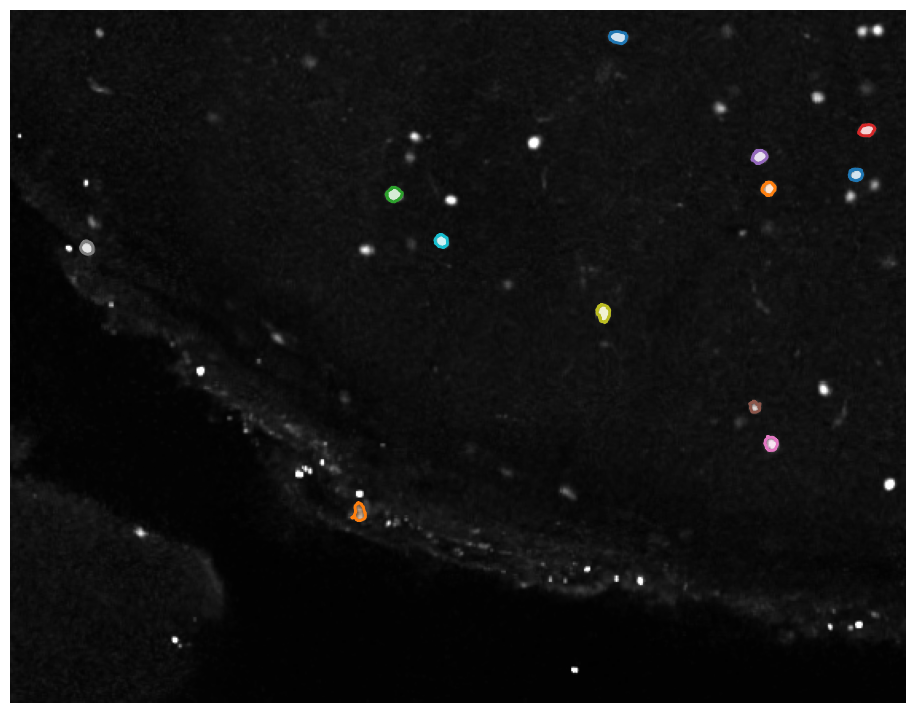

In [13]:
# Load pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = cd.fetch_model('ginoro_CpnResNeXt101UNet-fbe875f1a3e5ce2c', check_hash=True).to(device)
model.eval()

# Load input
img = cv2.imread('Data/Split-images/B00100/158.png',cv2.IMREAD_GRAYSCALE) #coins()
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
print(img.dtype, img.shape, (img.min(), img.max()))

# Run model
with torch.no_grad():
    x = cd.to_tensor(img, transpose=True, device=device, dtype=torch.float32)
    x = x / 255  # ensure 0..1 range
    x = x[None]  # add batch dimension: Tensor[3, h, w] -> Tensor[1, 3, h, w]
    y = model(x)

# Show results for each batch item
contours = y['contours']
for n in range(len(x)):
    cd.imshow(x[n], figsize=(16, 9))#titles=('input', 'contours')
    cd.plot_contours(contours[n])
    plt.axis('off')
    plt.savefig(f'contours_158.png',bbox_inches='tight', pad_inches=0)
    plt.show()

    

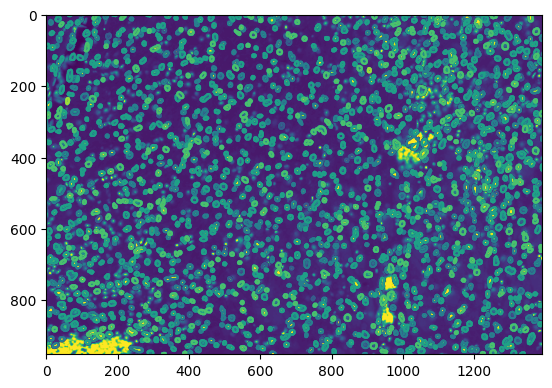

In [ ]:
# overlay contours on original image

orig_img = cv2.imread('img-pth',cv2.IMREAD_GRAYSCALE)
segmented_img = cv2.imread('img-path',cv2.IMREAD_GRAYSCALE)
plt.imshow(orig_img)
plt.contour(segmented_img)
plt.show()

## Automate splitting-inference-joining

## With padding


In [24]:
# Padding function to round dimensions up to the nearest multiple of 256
def pad_to_nearest_256(image):
    height, width = image.shape
    new_height = 256 * ((height + 255) // 256)
    new_width = 256 * ((width + 255) // 256)
    
    padded_image = np.zeros((new_height, new_width), dtype=image.dtype)
    padded_image[:height, :width] = image  # Copy original image into top-left corner
    return padded_image, (height, width)  # Return original dimensions for cropping after processing

# Split function
def split_image(image, patch_height, patch_width):
    print("inside split_image")
    img_height, img_width = image.shape
    patches = []
    num_patches_y = img_height // patch_height
    num_patches_x = img_width // patch_width

    for y in range(num_patches_y):
        for x in range(num_patches_x):
            start_y, start_x = y * patch_height, x * patch_width
            end_y, end_x = (y + 1) * patch_height, (x + 1) * patch_width
            patch = image[start_y:end_y, start_x:end_x]
            patches.append((patch, (start_y, end_y, start_x, end_x))) 
    return patches, (num_patches_y, num_patches_x)

# Model inference function
def get_result(img):
    print("inside get_result")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = cd.fetch_model('ginoro_CpnResNeXt101UNet-fbe875f1a3e5ce2c', check_hash=True).to(device)
    model.eval()

    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    with torch.no_grad():
        x = cd.to_tensor(img, transpose=True, device=device, dtype=torch.float32) / 255
        x = x[None]
        y = model(x)

    contours = y['contours'][0]  # Extract contours for the first batch element
    return contours  # Return raw contour data

# Processing each patch and stitching
# def process_and_stitch(image, patch_height, patch_width, original_shape):
#     print("inside process_and_stitch")
#     patches, (num_patches_y, num_patches_x) = split_image(image, patch_height, patch_width)
#     processed_patches = []

#     for patch, position in patches: #position is a tuple of (start_y, end_y, start_x, end_x) 
#         contours = get_result(patch)
#         processed_patches.append((contours, position))

#     stitched_image = np.zeros(image.shape, dtype=np.uint8)
#     for contours, (start_y, end_y, start_x, end_x) in processed_patches:
#         cd.plot_contours(contours, ax=plt.gca())
#         plt.axis('off')
#         plt.savefig('temp_contour.png', bbox_inches='tight', pad_inches=0)
#         contour_image = cv2.imread('temp_contour.png', cv2.IMREAD_GRAYSCALE)
#         stitched_image[start_y:end_y, start_x:end_x] = contour_image

    # # Crop back to original size
    # #stitched_image = stitched_image[:original_shape[0], :original_shape[1]]

    # plt.imshow(stitched_image, cmap='gray')
    # plt.axis('off')
    # plt.show()
    # return stitched_image
def process_and_stitch(image, patch_height, patch_width):
    print("inside process_and_stitch")
    patches, (num_patches_y, num_patches_x) = split_image(image, patch_height, patch_width)
    stitched_image = np.copy(image)  # Copy original image to draw contours on top

    for patch, (start_y, end_y, start_x, end_x) in patches:
        contours = get_result(patch)  # Get contours for the patch

        # Draw each contour over the corresponding area in the stitched image
        for contour in contours:
            # Shift contour coordinates to the correct position in the stitched image
            shifted_contour = contour.cpu().numpy() + np.array([start_x, start_y])
            cv2.drawContours(stitched_image, [shifted_contour.astype(np.int32)], -1, color=255, thickness=2)

    # Display the stitched image with padding
    plt.imshow(stitched_image, cmap='gray')
    plt.axis('off')
    plt.show()
    return stitched_image

# Load image function
def load_image(image_path):
    print("inside load_image")
    image = sitk.ReadImage(str(image_path))
    image = sitk.GetArrayFromImage(image)
    image[image < 0] = 0
    image = image.T
    image = np.flip(image, axis=1)
    image = np.squeeze(image)
    print("image loaded")
    return image

In [21]:
# create an empty sample image with 1280x1280 pixels
sample_image = np.zeros((120, 1200), dtype=np.uint8)

inside load_image


TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


image loaded
inside process_and_stitch
inside split_image
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside get_result
inside

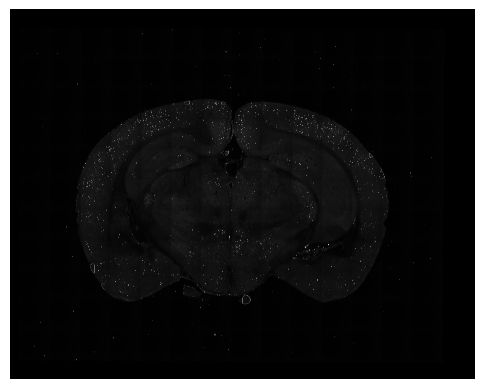

In [ ]:
## main func

# Load the TIFF image
img_path = "imgpth"
image = load_image(img_path)
image = image[2]

# Pad image to nearest 256 multiple
padded_image, original_shape = pad_to_nearest_256(image)

# Define patch size
patch_height, patch_width = 256, 256

# Process and stitch
stitched_image = process_and_stitch(padded_image, patch_height, patch_width)



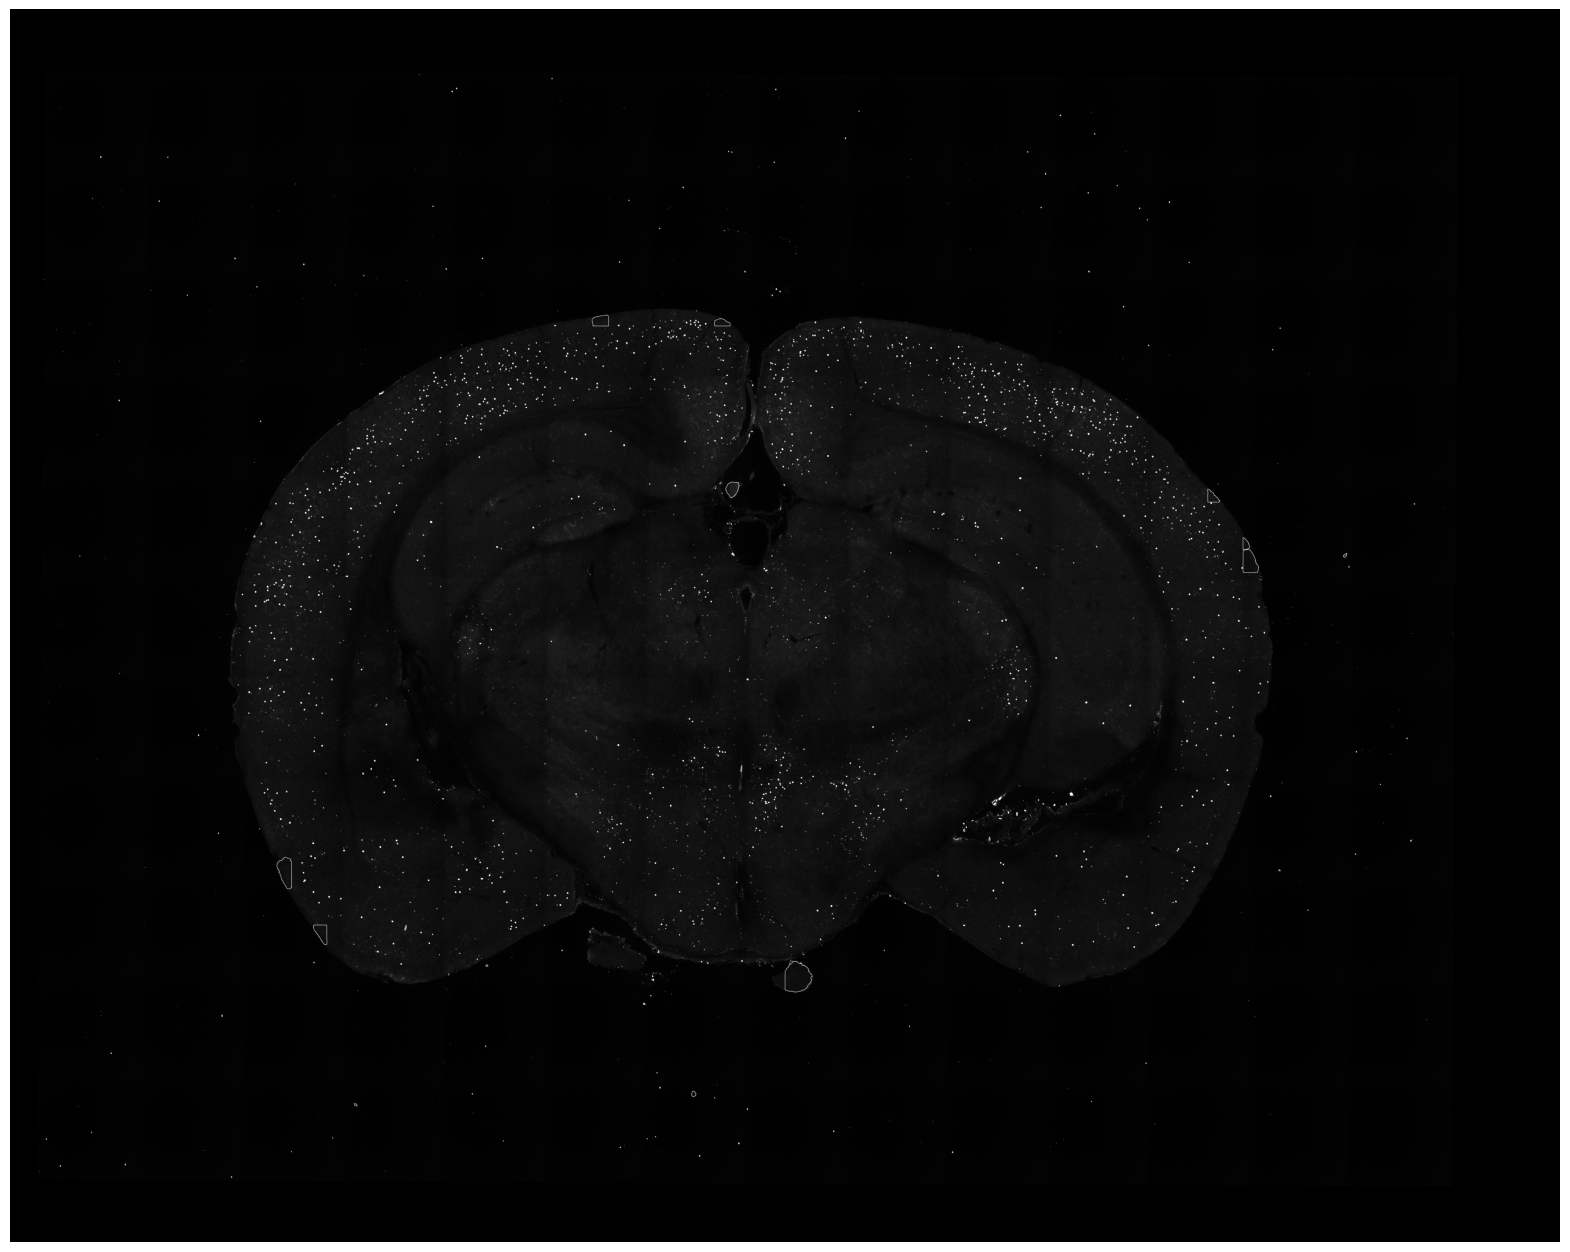

In [28]:
plt.figure(figsize=(20, 20))  # Set the figure size to be large for HD quality
plt.imshow(stitched_image, cmap='gray')
plt.axis('off')  # Hide the axis
plt.savefig('stitched_image_hd.png', bbox_inches='tight', pad_inches=0, dpi=600)  # Save the image with high resolution
plt.show()  # Display the image